<a href="https://colab.research.google.com/github/Mageed-Ghaleb/OptimizationSystems-Course/blob/main/Two_stage_Stochastic_LP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 08 companion lab — Two-Stage Production Planning Under Uncertainty (Stochastic + Robust Stress Test)

**Topic:** Uncertainty: robust & two-stage stochastic optimization  
**Tools:** Pyomo + HiGHS (LP solver)

This lab is fully contained: it introduces the modeling ideas, gives the math, then implements everything end-to-end.

## Learning goals
- Build a **two-stage stochastic linear program** (here-and-now + recourse).
- Encode scenarios and solve the **extensive form** in Pyomo.
- Evaluate solutions by **scenario stress-testing**.
- Compare **deterministic**, **stochastic**, and **budgeted-uncertainty stress tests (Γ)**.

## Model story (single product, T periods)
Stage 1 (here-and-now): baseline production `x[t]` chosen before demand is known.  
Stage 2 (recourse, per scenario s): overtime `o[s,t]`, inventory `I[s,t]`, backorder `B[s,t]`.

### Inventory balance (with backorders)
For each scenario s and period t:

(I[s,t] - B[s,t]) = (I[s,t-1] - B[s,t-1]) + x[t] + o[s,t] - d[s,t]

### Objective (two-stage stochastic LP)
min  Σ_t c_prod[t] x[t]  +  Σ_s π[s] Σ_t ( c_ot[t] o[s,t] + h[t] I[s,t] + p[t] B[s,t] )

We solve:
1) Deterministic model using nominal demand only  
2) Two-stage stochastic extensive form with sampled scenarios  
3) Stress-test both solutions under scenarios  
4) Budgeted “Γ” stress test inspired by robust optimization

In [1]:
!pip -q install pyomo highspy
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, NonNegativeReals, Constraint, Objective, minimize, SolverFactory, value
#
np.random.seed(7)
solver = SolverFactory("highs")
print("HiGHS available:", solver.available())

HiGHS available: True


In [2]:
### Data
T = 4
periods = list(range(1, T+1))

# Costs
c_prod = {1: 4.0, 2: 4.0, 3: 4.2, 4: 4.2}
c_ot   = {1: 7.5, 2: 7.5, 3: 8.0, 4: 8.0}
h      = {1: 0.6, 2: 0.6, 3: 0.7, 4: 0.7}
p_pen  = {1: 9.0, 2: 9.0, 3: 9.5, 4: 9.5}

# Capacities
cap    = {1: 60, 2: 60, 3: 55, 4: 55}
cap_ot = {1: 25, 2: 25, 3: 20, 4: 20}

I0, B0 = 0.0, 0.0

# Nominal forecast
d_nom = {1: 50, 2: 65, 3: 60, 4: 55}

pd.DataFrame({
    "period": periods,
    "cap": [cap[t] for t in periods],
    "cap_ot": [cap_ot[t] for t in periods],
    "c_prod": [c_prod[t] for t in periods],
    "c_ot": [c_ot[t] for t in periods],
    "h": [h[t] for t in periods],
    "p": [p_pen[t] for t in periods],
    "d_nom": [d_nom[t] for t in periods],
})

,period,cap,cap_ot,c_prod,c_ot,h,p,d_nom
0,1,60,25,4.0,7.5,0.6,9.0,50
1,2,60,25,4.0,7.5,0.6,9.0,65
2,3,55,20,4.2,8.0,0.7,9.5,60
3,4,55,20,4.2,8.0,0.7,9.5,55


In [3]:
### scenario sampling
S = 20
scenarios = list(range(1, S+1))
pi = {s: 1.0/S for s in scenarios}

sigma_frac = 0.15
d = {}
for s in scenarios:
    for t in periods:
        noise = np.random.normal(0.0, sigma_frac * d_nom[t])
        d[(s,t)] = max(0.0, d_nom[t] + noise)

pd.DataFrame({
    "scenario": np.repeat(scenarios, T),
    "period": periods * S,
    "demand": [d[(s,t)] for s in scenarios for t in periods]
}).pivot_table(index="scenario", columns="period", values="demand").head()

period,1,2,3,4
scenario,,,,
1,62.678943,60.457111,60.295381,58.362009
2,44.083077,65.020139,59.991987,40.523524
3,57.632435,70.854861,54.371139,53.584727
4,53.789745,62.451775,57.815258,43.010758
5,54.159352,66.207839,62.470139,42.406173


In [4]:
### build deterministic + stochastic models
def build_model(demand, stochastic=False):
    m = ConcreteModel()
    m.T = pyo.Set(initialize=periods, ordered=True)

    if stochastic:
        m.S = pyo.Set(initialize=scenarios, ordered=True)

    m.x = Var(m.T, within=NonNegativeReals)
    m.cap_con = Constraint(m.T, rule=lambda m,t: m.x[t] <= cap[t])

    if not stochastic:
        m.o = Var(m.T, within=NonNegativeReals)
        m.I = Var(m.T, within=NonNegativeReals)
        m.B = Var(m.T, within=NonNegativeReals)

        m.cap_ot_con = Constraint(m.T, rule=lambda m,t: m.o[t] <= cap_ot[t])

        def bal(m, t):
            prev = (I0 - B0) if t==1 else (m.I[t-1] - m.B[t-1])
            return (m.I[t] - m.B[t]) == prev + m.x[t] + m.o[t] - demand[t]
        m.balance = Constraint(m.T, rule=bal)

        m.obj = Objective(
            expr=sum(c_prod[t]*m.x[t] for t in m.T) +
                 sum(c_ot[t]*m.o[t] + h[t]*m.I[t] + p_pen[t]*m.B[t] for t in m.T),
            sense=minimize
        )
        return m

    m.o = Var(m.S, m.T, within=NonNegativeReals)
    m.I = Var(m.S, m.T, within=NonNegativeReals)
    m.B = Var(m.S, m.T, within=NonNegativeReals)

    m.cap_ot_con = Constraint(m.S, m.T, rule=lambda m,s,t: m.o[s,t] <= cap_ot[t])

    def bal(m, s, t):
        prev = (I0 - B0) if t==1 else (m.I[s,t-1] - m.B[s,t-1])
        return (m.I[s,t] - m.B[s,t]) == prev + m.x[t] + m.o[s,t] - demand[(s,t)]
    m.balance = Constraint(m.S, m.T, rule=bal)

    m.obj = Objective(
        expr=sum(c_prod[t]*m.x[t] for t in m.T) +
             sum(pi[s]*sum(c_ot[t]*m.o[s,t] + h[t]*m.I[s,t] + p_pen[t]*m.B[s,t] for t in m.T)
                 for s in m.S),
        sense=minimize
    )
    return m

In [5]:
### solve deterministic and stochastic
m_det = build_model(d_nom, stochastic=False)
solver.solve(m_det, tee=False)
x_det = {t: value(m_det.x[t]) for t in periods}
obj_det = value(m_det.obj)

m_sp = build_model(d, stochastic=True)
solver.solve(m_sp, tee=False)
x_sp = {t: value(m_sp.x[t]) for t in periods}
obj_sp = value(m_sp.obj)

pd.DataFrame({
    "period": periods,
    "x_det": [x_det[t] for t in periods],
    "x_stoch": [x_sp[t] for t in periods],
    "d_nom": [d_nom[t] for t in periods],
})

,period,x_det,x_stoch,d_nom
0,1,60.0,59.056779,50
1,2,60.0,60.000000,65
2,3,55.0,55.000000,60
3,4,55.0,47.714664,55


In [6]:
### stress test both plans on scenarios
def solve_recourse_for_x(x_fixed, demand_s):
    m = ConcreteModel()
    m.T = pyo.Set(initialize=periods, ordered=True)
    m.o = Var(m.T, within=NonNegativeReals)
    m.I = Var(m.T, within=NonNegativeReals)
    m.B = Var(m.T, within=NonNegativeReals)

    m.cap_ot = Constraint(m.T, rule=lambda m,t: m.o[t] <= cap_ot[t])

    def bal(m, t):
        prev = (I0 - B0) if t==1 else (m.I[t-1] - m.B[t-1])
        return (m.I[t] - m.B[t]) == prev + x_fixed[t] + m.o[t] - demand_s[t]
    m.balance = Constraint(m.T, rule=bal)

    m.obj = Objective(expr=sum(c_ot[t]*m.o[t] + h[t]*m.I[t] + p_pen[t]*m.B[t] for t in m.T), sense=minimize)
    solver.solve(m, tee=False)
    return value(m.obj), {t:value(m.B[t]) for t in periods}

def evaluate_plan(x_plan, demand_dict):
    costs, backs = [], []
    for s in scenarios:
        dem = {t: demand_dict[(s,t)] for t in periods}
        rec, B = solve_recourse_for_x(x_plan, dem)
        total = sum(c_prod[t]*x_plan[t] for t in periods) + rec
        costs.append(total)
        backs.append(sum(B.values()))
    costs = np.array(costs); backs = np.array(backs)
    return {
        "mean": float(costs.mean()),
        "std": float(costs.std()),
        "p90": float(np.quantile(costs, 0.90)),
        "max": float(costs.max()),
        "mean_backorder": float(backs.mean()),
        "all_costs": costs
    }

eval_det = evaluate_plan(x_det, d)
eval_sp  = evaluate_plan(x_sp, d)

pd.DataFrame([
    {"plan":"deterministic", **{k:eval_det[k] for k in ["mean","std","p90","max","mean_backorder"]}},
    {"plan":"stochastic", **{k:eval_sp[k] for k in ["mean","std","p90","max","mean_backorder"]}},
])

,plan,mean,std,p90,max,mean_backorder
0,deterministic,1023.44015,59.881130,1127.287908,1170.761285,0.0
1,stochastic,1014.51514,78.910469,1136.509228,1188.485515,0.0


In [7]:
### budgeted Γ stress test (robust-inspired)
delta_frac = 0.20
d_hi = {t: d_nom[t]*(1+delta_frac) for t in periods}

def adversarial_demands_budgeted(Gamma):
    order = sorted(periods, key=lambda t: d_nom[t], reverse=True)
    hi_periods = set(order[:Gamma])
    return {t: (d_hi[t] if t in hi_periods else d_nom[t]) for t in periods}, hi_periods

def budgeted_stress(plans, Gammas):
    rows = []
    for G in Gammas:
        dem, hi = adversarial_demands_budgeted(G)
        for name, x_plan in plans.items():
            rec, B = solve_recourse_for_x(x_plan, dem)
            total = sum(c_prod[t]*x_plan[t] for t in periods) + rec
            rows.append({"Gamma":G, "plan":name, "total_cost":total,
                         "total_backorder":sum(B.values()),
                         "hi_periods":",".join(map(str,sorted(hi)))})
    return pd.DataFrame(rows)

df_stress = budgeted_stress({"deterministic":x_det, "stochastic":x_sp}, Gammas=[0,1,2,3,4])
df_stress.pivot_table(index="Gamma", columns="plan", values=["total_cost","total_backorder"], aggfunc="first")

total_backorder               total_cost             
plan    deterministic stochastic deterministic   stochastic
Gamma                                                      
0                 0.0        0.0         951.0   981.325298
1                 0.0        0.0        1048.0  1078.419620
2                 0.0        0.0        1144.0  1174.419620
3                 0.0        0.0        1232.0  1262.419620
4                 0.0        0.0        1301.0  1331.985553

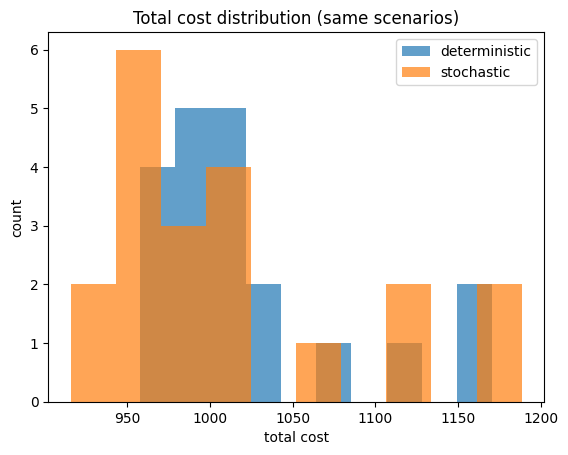

In [8]:
### plot distributions
import matplotlib.pyplot as plt
#
plt.figure()
plt.hist(eval_det["all_costs"], bins=10, alpha=0.7, label="deterministic")
plt.hist(eval_sp["all_costs"], bins=10, alpha=0.7, label="stochastic")
plt.legend()
plt.title("Total cost distribution (same scenarios)")
plt.xlabel("total cost")
plt.ylabel("count")
plt.show()